# DS4A: MinJusticia
## Reducing the recidivim risk for people released from jail between 2010 and 2019 <br> 

**Team 77** <br>
**Members:** Sergio Bernal, Wilfer Carvajal , Diego Costa, Laura Goyeneche, Esneyder Guerrero, Daniel Hoyos, Katerin Lopez <br>
**Last modificaiton:** July 25, 2020 

## Context

The Ministry of Justice leads the development of public policies that guarantee the effective protection of the rights of their citizens. Currently, the penitentiary and prison entities are interested in characterizing the jail population in Colombia and their recidivism risk to ensure an adequate formulation and monitoring of the criminal policy. <br><br>

## ML objective

Predict the risk of recidivism within X year(s) of their release date for individuals that had been in jail at least once.

## Basic

In [690]:
# Libraries
# Warning
from warnings import filterwarnings
filterwarnings('ignore')

# Basic
import json
import numpy  as np
import pandas as pd
from urllib.request import urlopen
from collections    import defaultdict

# Connect db
from app.backend.utils     import DbEngine, Queries
from app.backend.etl       import ETL
from app.backend.etl_sdhi  import ETL_SDHI
from app.utils.metrics     import * 
from app.utils.plots       import *
from app.utils.train_test  import *
from app.utils.gs_model    import *
from app.utils.model_setup import *
from app.utils.plot_labels import *

# Sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import cohen_kappa_score

# Enconding
from app.encoding_module import encoder

# Visualization
import seaborn           as sns
import matplotlib.pyplot as plt

# Plotly
import plotly.express        as px
import plotly.figure_factory as ff
import plotly.graph_objects  as go

%matplotlib inline
plt.style.use('seaborn')

### Connect to DB

In [2]:
db_engine = DbEngine(user     = 'team77', 
                     password = 'mintic2020.', 
                     ip       = 'localhost', 
                     port     = '5432', 
                     db       = 'minjusticia') 

engine    = db_engine.connect()
queries   = Queries(engine)

### Dataframe

In [699]:
encoding = encoder.Encoding(queries)
inmate   = encoding.get_data('recidivism')
inmate   = encoding.supervised(inmate)

In [723]:
inmategeo = encoding.get_data('etl_select_8')

## Supervised modeling

### Gridsearch

In [4]:
# Split data based on time
train_start = 2010
train_end   = 2017
test_start  = 2018
test_end    = 2019

In [5]:
# Gridsearch across multiple month thresholds
sets    = dict()
results = dict()
for month in [6, 12, 18, 24]:
    # Train and test sets
    sets[month] = train_test(inmate, train_start, train_end, test_start, test_end, month)
    X_train, y_train, X_test, y_test = sets[month]
    
    # Gridsearch
    results[month] = model_search(X_train, y_train, models, params)

Train set: 2949 out of 74286 ~ 4.0%
Test  set: 1000 out of 25800 ~ 4.0%
LR
NB
KNN
DT
RF
GB
Train set: 5517 out of 74286 ~ 7.0%
Test  set: 2006 out of 25800 ~ 8.0%
LR
NB
KNN
DT
RF
GB
Train set: 7709 out of 74286 ~ 10.0%
Test  set: 2977 out of 25800 ~ 12.0%
LR
NB
KNN
DT
RF
GB
Train set: 14298 out of 74286 ~ 19.0%
Test  set: 4909 out of 25800 ~ 19.0%
LR
NB
KNN
DT
RF
GB


### Results dataframe

In [448]:
def baseline_t(y, y_hat, t):
    y_pred = binprob(y_hat, t)
    score  = cohen_kappa_score(y, y_pred)
    return score

In [488]:
k       = 0.1
metrics = defaultdict(list)
y_preds = defaultdict()
for month in [6, 12, 18, 24]:
    y_preds[month] = defaultdict()
    
    for model in list(models.keys()):
        y_test = sets[month][3]
        y_pred = results[month][model].predict_proba(sets[month][2])
        y_preds[month][model] = y_pred
        
        metrics['accuracy' ].append(accuracy_t (y_test, y_pred[:,1], k))
        metrics['precision'].append(precision_t(y_test, y_pred[:,1], k))
        metrics['recall'   ].append(recall_t   (y_test, y_pred[:,1], k))
        metrics['f1'       ].append(f1_t       (y_test, y_pred[:,1], k))
        metrics['baseline' ].append(baseline_t (y_test, y_pred[:,1], k))
        metrics['month'    ].append(month)
        metrics['model'    ].append(model)

In [489]:
metrics = pd.DataFrame(metrics)

### Metrics comparison

In [477]:
nme_dict = {'LR':'Logistic Regression',
            'NB':'Naive Bayes',
            'KNN':'K-Neighbors',
            'DT':'Decision Tree',
            'RF':'Random Forest',
            'GB':'Gradient Boosting'}

In [490]:
metrics[metrics.month == 24]

,accuracy,precision,recall,f1,baseline,month,model
18,0.781628,0.359551,0.189041,0.247797,0.134272,24,LR
19,0.780310,0.420223,0.407211,0.413615,0.278491,24,NB
20,0.801163,0.466218,0.310654,0.372861,0.260300,24,KNN
21,0.812054,0.511450,0.272968,0.355957,0.257652,24,DT
22,0.850465,0.703603,0.369933,0.484913,0.407175,24,RF
23,0.855891,0.730725,0.384192,0.503605,0.428687,24,GB


In [564]:
results[24]['LR']

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [563]:
np.sqrt(X_train.shape[1]), X_train.shape[1]

(15.198684153570664, 231)

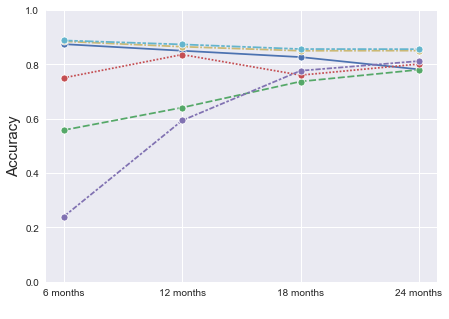

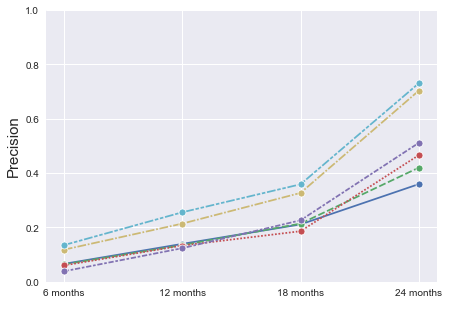

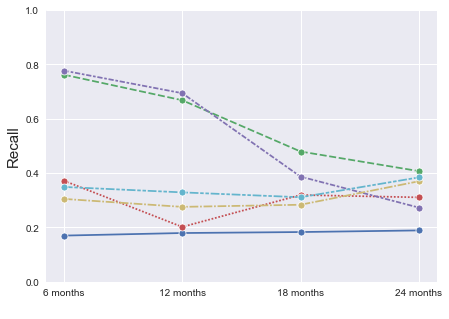

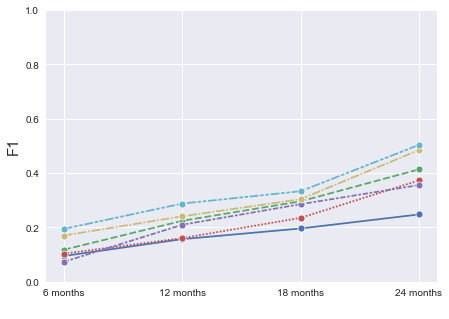

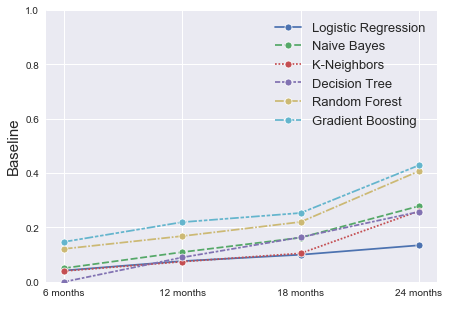

In [482]:
# Plot
#plt.figure(figsize = (13,15))
for i,nme in enumerate(list(metrics.columns[:5])):
    plt.figure(figsize = (7,5))
    #plt.subplot(3,2,i+1)
    sns.lineplot(x = 'month', y = nme, hue = 'model', data = metrics, style = 'model', marker = 'o')
    plt.ylim(0,1)
    plt.xticks([6, 12, 18, 24], ['6 months','12 months','18 months','24 months'])
    plt.ylabel(nme.title(), fontsize = 15)
    plt.xlabel(' ')
    if nme == 'baseline':
        plt.legend(nme_dict.values(), fontsize = 13)
    else:
        plt.legend('', title = '')
    plt.show()
    
#plt.show()

### Precision-Recall @k 

In [515]:
def precision_recall_t(month):
    plt.figure(figsize = (23,13))
    for i,model in enumerate(list(models.keys())):
        y_test = sets[month][3]
        y_pred = y_preds[month][model][:,1]

        pc, rc, pr_t = precision_recall_curve(y_test, y_pred)
        pc = pc[:-1]
        rc = rc[:-1]

        above_threshold = []
        number_scored   = len(y_pred)

        for value in pr_t:
            num_above_thresh = len(y_pred[y_pred >= value])
            pct_above_thresh = num_above_thresh/float(number_scored)
            above_threshold.append(pct_above_thresh)

        above_threshold = np.array(above_threshold)

        plt.subplot(2,3,i+1)
        plt.plot(above_threshold, pc, color = 'b')
        plt.ylabel('Precision', color = 'b', fontsize = 12)
        plt.ylim(0,1)
        #ax1.set_ylabel('Precision', color = 'b', fontsize = 12)
        ax2 = plt.twinx()
        plt.plot(above_threshold, rc, color = 'r')
        ax2.set_ylabel('Recall', color = 'r', fontsize = 12)
        plt.title('PR@k model {}'.format(model), fontsize = 16)
        
    plt.show()       

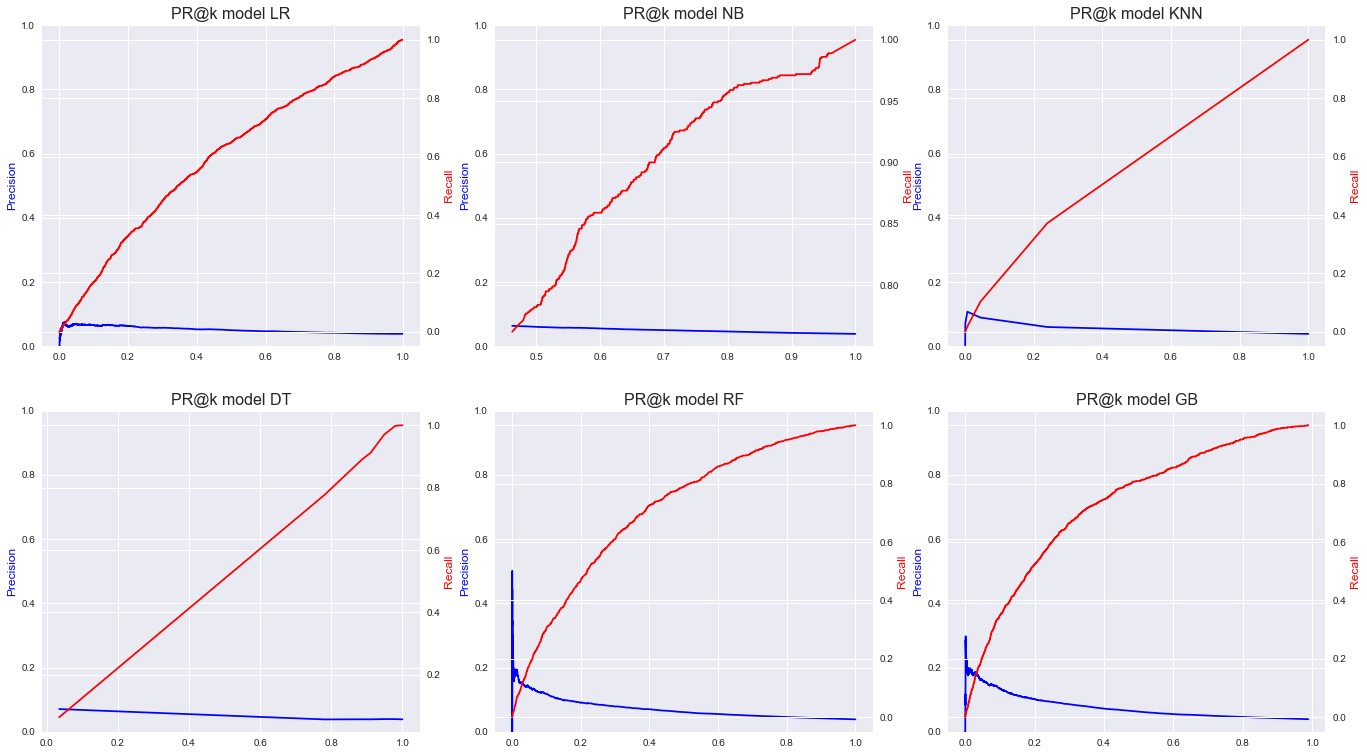

In [519]:
precision_recall_t(6)

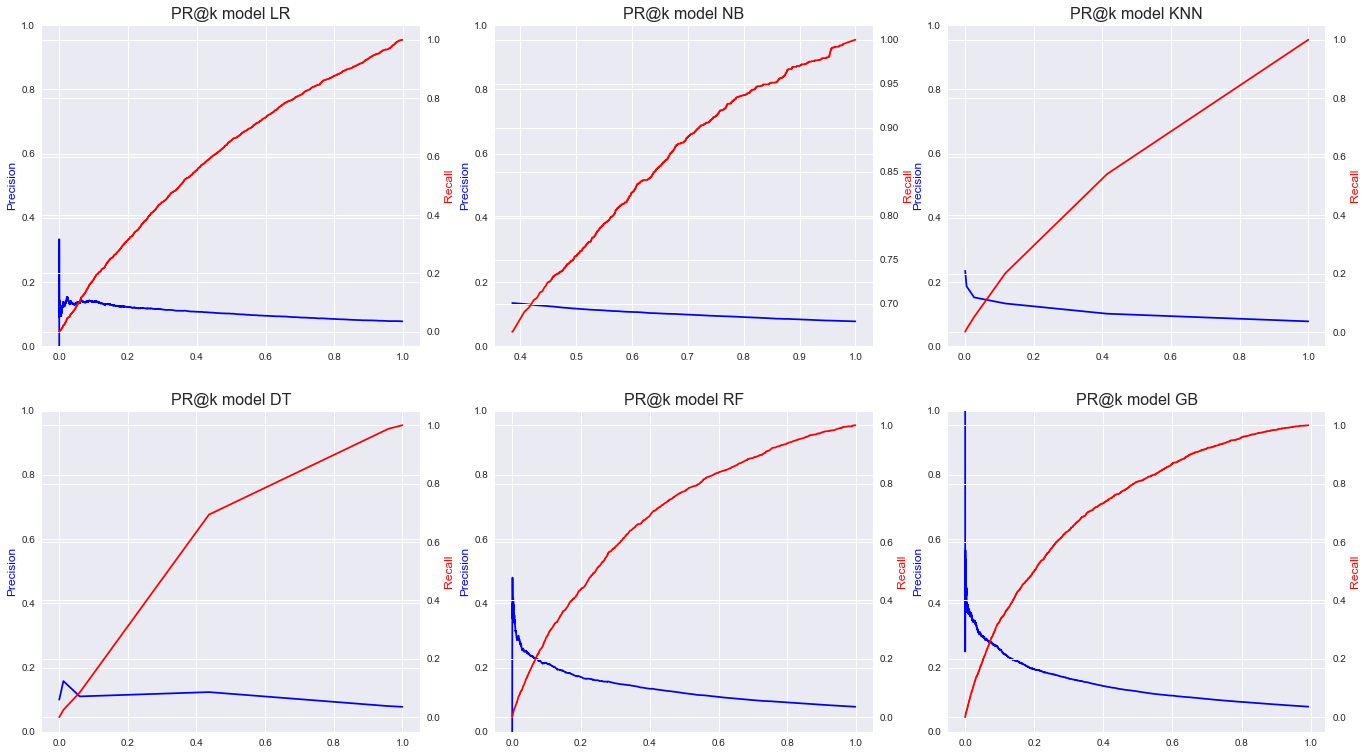

In [518]:
precision_recall_t(12)

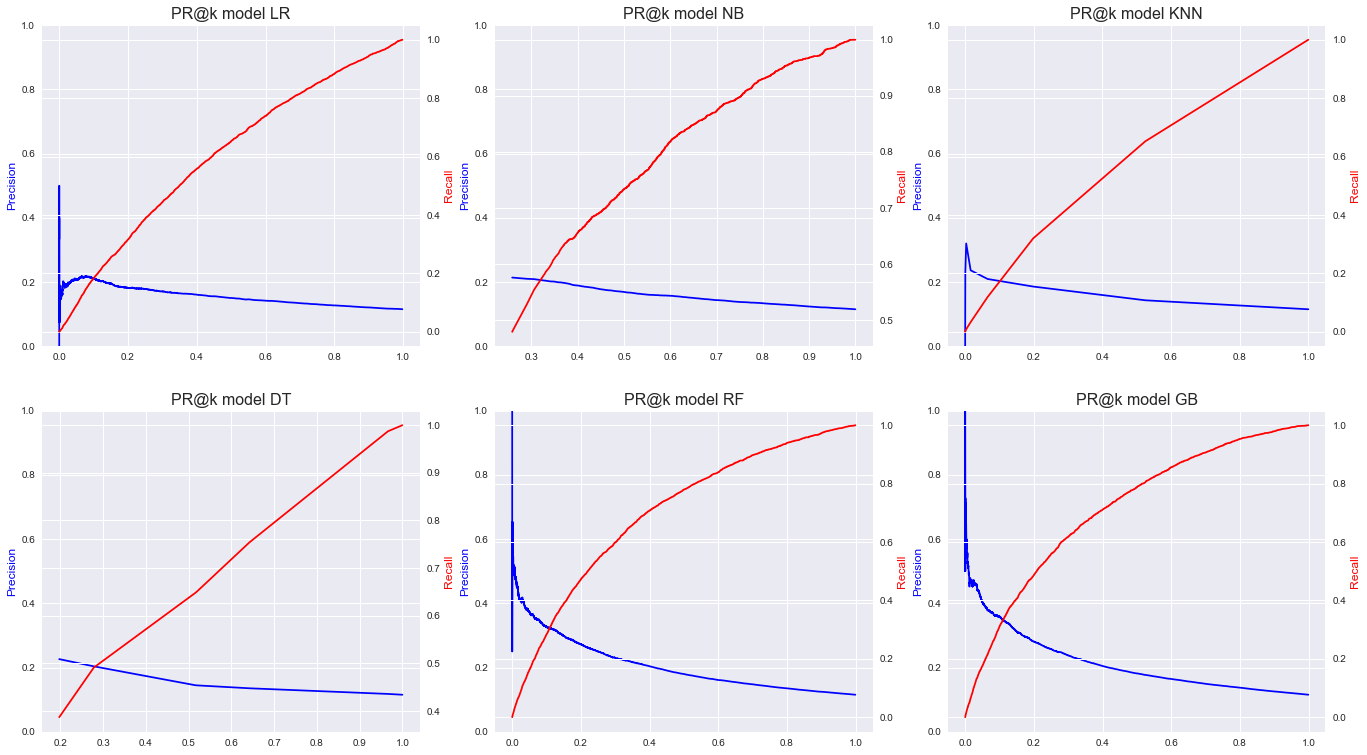

In [517]:
precision_recall_t(18)

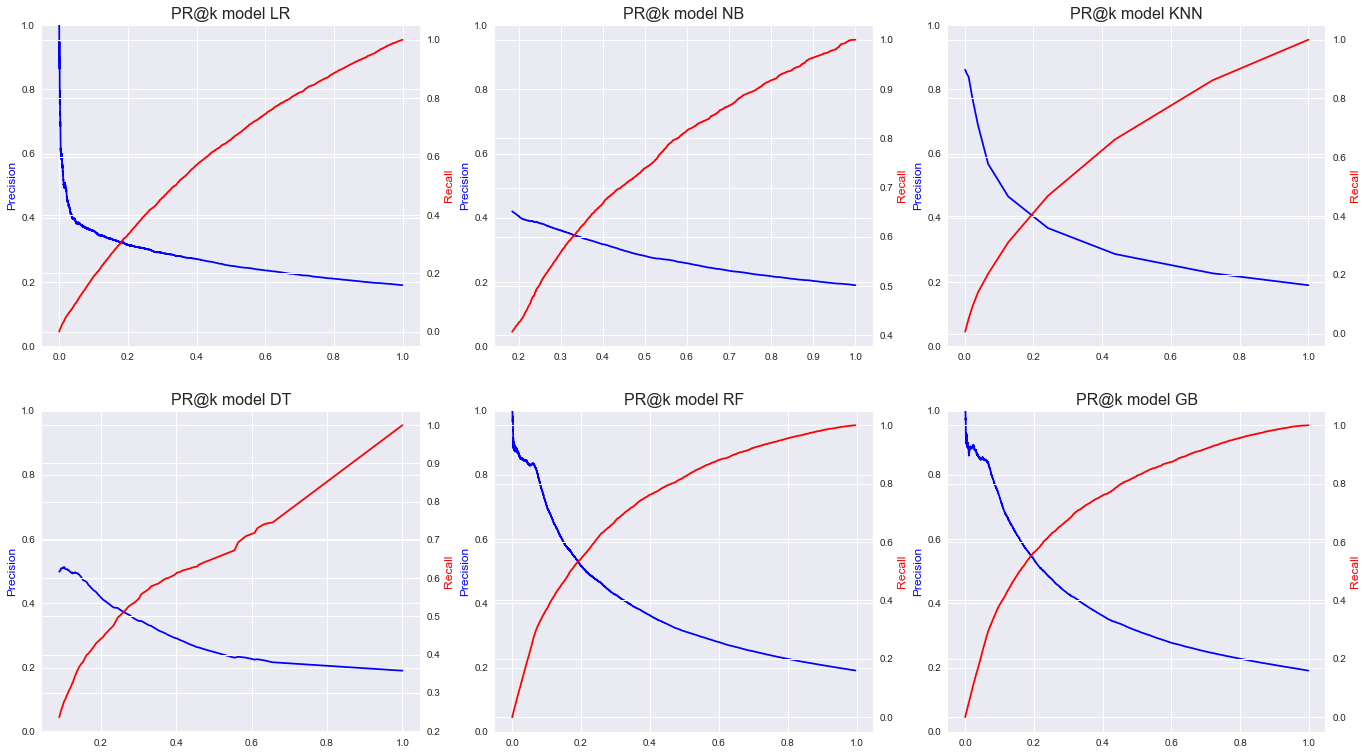

In [516]:
precision_recall_t(24)

### AUC - ROC

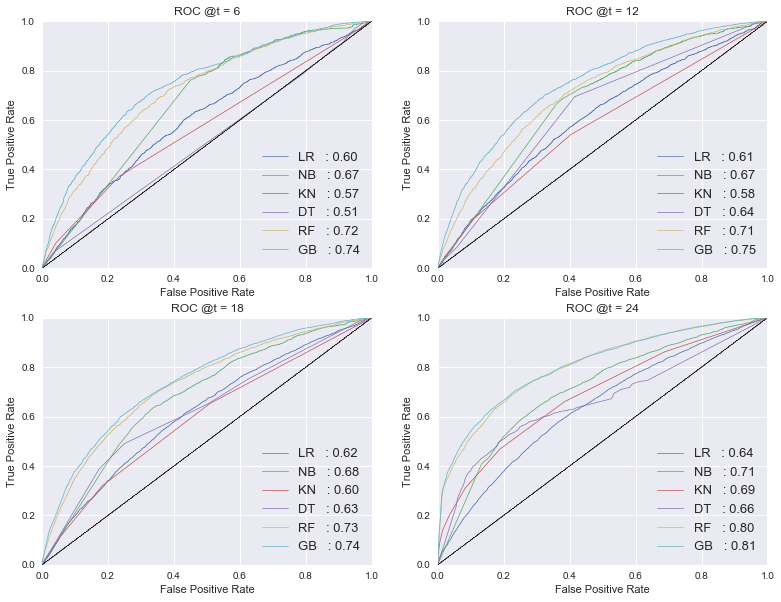

In [522]:
plt.figure(figsize = (13,10))

for i,month in enumerate([6, 12, 18, 24]):
    plt.subplot(2,2,i+1)
    for model in list(models.keys()):
        y_test = sets[month][3]
        y_pred = y_preds[month][model][:,1]
        fpr, tpr, t = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label = '%-5.2s: %0.2f' % (model, roc_auc), linewidth = 0.7)
        plt.plot([0, 1], [0, 1], 'black', linestyle = '--', linewidth = 0.4)
        plt.legend(loc = 'lower right', fontsize = 13)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.title('ROC @t = {}'.format(month))
    
plt.show()

### Feature importance

In [540]:
temp['DELITO_COMP_MANUFACTURING TRAFFIC OR SUPPORT OF NARCOTICS'] = 'Crime: Manufacturing, traffic\nand support narcotics'

In [552]:
temp['DELITO_COMP_MANUFACTURE, TRAFFIC, PORTION OR TENURE OF FIREARMS, ACCESSORIES, PARTS OR AMMUNITIONS'] = 'Crime: Manufaturing, traffic\nportion of firears, ammunitions'

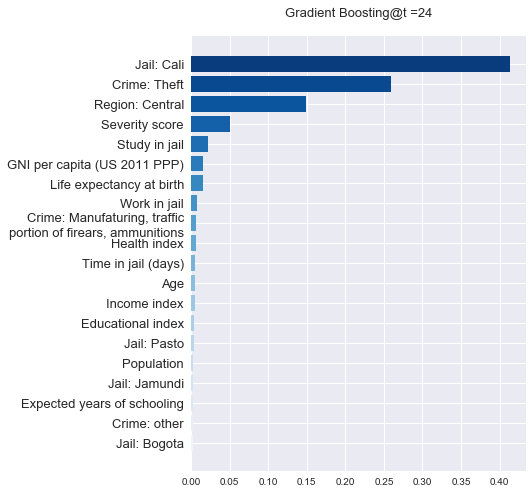

In [554]:
month = 24
model = 'GB'
n     = 20

features  = sets[month][0].columns
important = results[month][model].feature_importances_
idxs      = np.argsort(important)[-n:]

plt.figure(figsize = (6,8))
plt.barh(range(len(idxs)), important[idxs], color = sns.color_palette(pal,n))
plt.yticks(range(len(idxs)), [temp[features[i]] for i in idxs], fontsize = 13)
#plt.title('Random Forest@t ={}\n'.format(month), fontsize = 13)
plt.title('Gradient Boosting@t ={}\n'.format(month), fontsize = 13)
plt.show()

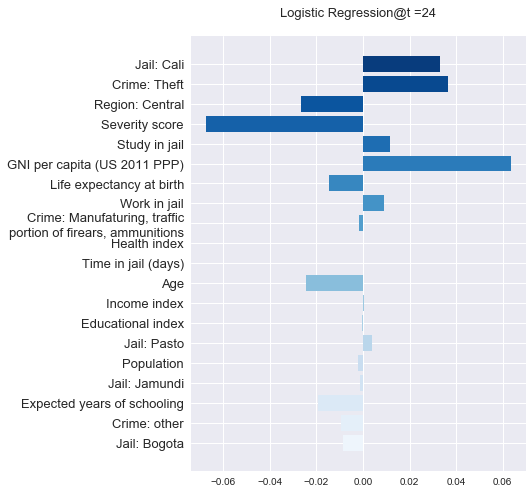

In [555]:
month = 24
model = 'LR'
n     = 20
pal   = 'Blues'

#features  = sets[month][0].columns
important = results[month][model].coef_[0]
#idxs      = np.argsort(abs(important))[-n:]

plt.figure(figsize = (6,8))
plt.barh(range(len(idxs)), important[idxs], color = sns.color_palette(pal,n))
plt.yticks(range(len(idxs)), [temp[features[i]] for i in idxs], fontsize = 13)
plt.title('Logistic Regression@t ={}\n'.format(month), fontsize = 13)
plt.show()

### Further analysis

In [569]:
yhat06 = results[6 ]['RF'].predict_proba(sets[6 ][2])[:,1]
yhat12 = results[12]['RF'].predict_proba(sets[12][2])[:,1]
yhat18 = results[18]['RF'].predict_proba(sets[18][2])[:,1]
yhat24 = results[24]['RF'].predict_proba(sets[24][2])[:,1]

In [700]:
inmate_hat = inmate.copy()
inmate_hat['age'] = 2020 - inmate_hat.ANIO_NACIMIENTO
inmate_hat.drop(columns = ['ANIO_NACIMIENTO',
                           'FECHA_SALIDA_t_1',
                           'FECHA_INGRESO',
                           'FECHA_SALIDA',
                           'INTERNOEN',
                           'year',
                           'recidivism_day'], inplace = True)

In [701]:
inmate['yhat06'] = results[6 ]['RF'].predict_proba(inmate_hat)[:,1]
inmate['yhat12'] = results[12]['RF'].predict_proba(inmate_hat)[:,1]
inmate['yhat18'] = results[18]['RF'].predict_proba(inmate_hat)[:,1]
inmate['yhat24'] = results[24]['RF'].predict_proba(inmate_hat)[:,1]

In [724]:
inmategeo['n_delitos']   = inmategeo.groupby(['persona_id_persona','fecha_ingreso']).transform('count')['delito_id_delito']
inmategeo.rename(columns = {'persona_id_persona':'id_persona','fecha_ingreso':'FECHA_INGRESO'}, inplace = True)

In [726]:
inmategeo.FECHA_INGRESO = pd.to_datetime(inmategeo.FECHA_INGRESO)

In [715]:
inmate2 = encoding.get_data('encoding')
inmate2 = inmate2[['id_persona','internoen']]

In [733]:
inmatemp = inmategeo.merge(inmate2, how = 'left')

In [735]:
inmatemp = inmatemp.rename(columns = {'internoen':'INTERNOEN'})

In [736]:
inmate_F = inmate.copy()

In [737]:
inmate_F = inmate_F.merge(inmatemp[['INTERNOEN','FECHA_INGRESO','nombre','n_delitos']].drop_duplicates(), 
                          how = 'left', 
                          on = ['INTERNOEN'])

In [999]:
tinmateF = inmate_F[['INTERNOEN','FECHA_INGRESO_x','nombre','yhat18','yhat24','timejail_day','SEVERITY',
                     'GENERO','ANIO_NACIMIENTO','recidivism_day','DELITO_COMP_HOMICIDE','ESCH',
                     'DELITO_COMP_AGRA_CALF_THEFT','MARITALSTATUS_SINGLE','HIJOS_MENORES']]

In [1000]:
tinmateF.to_csv('inmate_riskscore.csv', index = False)